<div align = "center">

# **Modelos GARCH**

</div>

## Librerias

In [23]:
import pandas as pd
import statsmodels
import arch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

from sklearn.model_selection import train_test_split
from arch import arch_model
import warnings
warnings.filterwarnings('ignore')

## Data

In [24]:
# Cargar datos con manejo de errores y conversión de tipos
sp500 = pd.read_csv("../data/input/sp500.csv")["Close"]

# Calcular retornos logarítmicos
retornos = np.log(sp500 / sp500.shift(1)) * 100

# Calcular volatilidad histórica (ventana de 7 días)
historica = retornos.rolling(window=7).std()

# Cargar datos de VIX y convertir a escala decimal (dividir por 100)
implicada = (pd.read_csv("../data/input/vix.csv")["Close"] / 10) - 1

print("=== VERIFICACIÓN DE ESCALAS ===")
print(f"Volatilidad histórica - Rango: [{historica.min():.4f}, {historica.max():.4f}]")
print(f"VIX (convertido) - Rango: [{implicada.min():.4f}, {implicada.max():.4f}]")

=== VERIFICACIÓN DE ESCALAS ===
Volatilidad histórica - Rango: [0.1862, 5.1465]
VIX (convertido) - Rango: [0.1860, 4.2330]


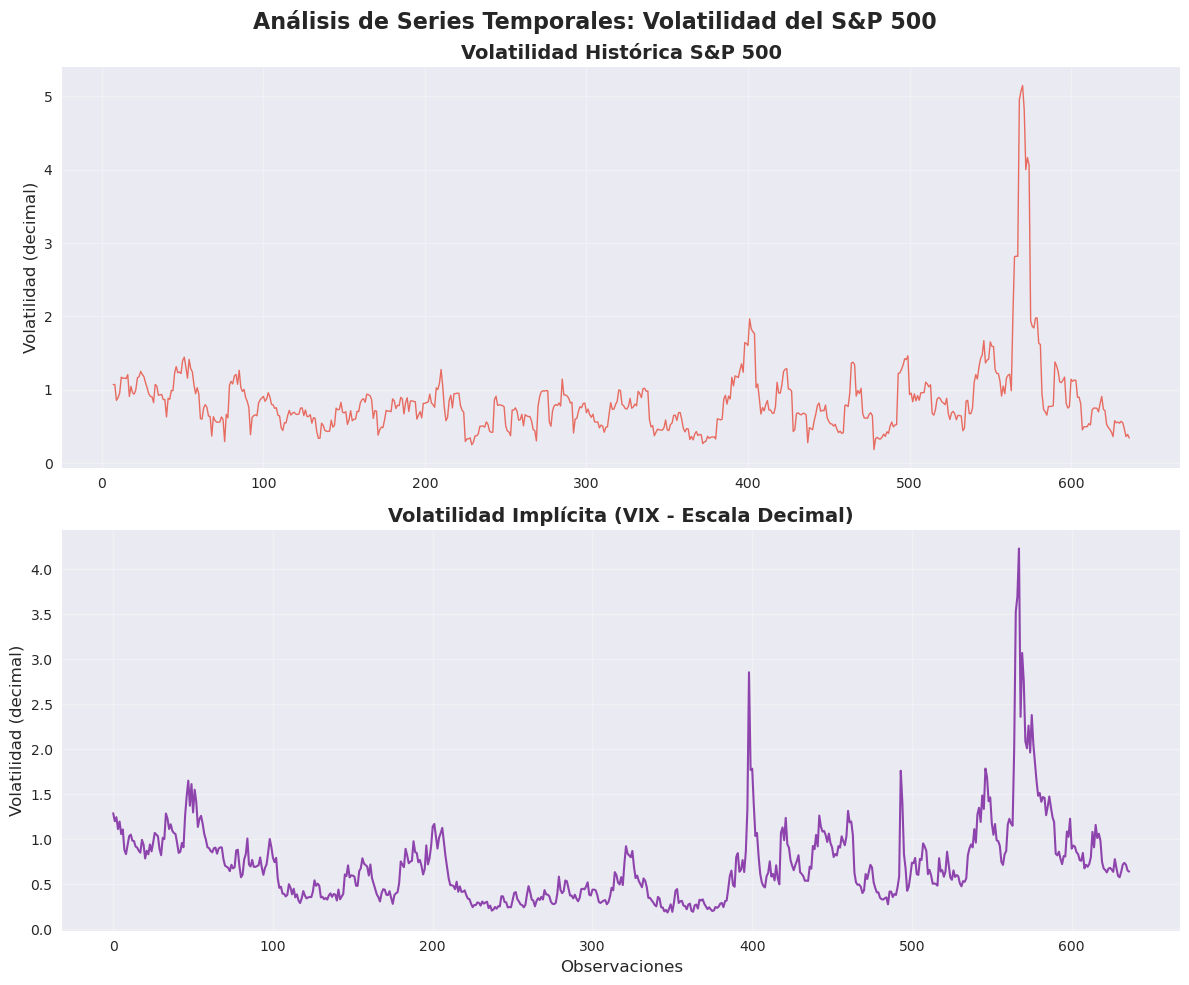

In [25]:
# Configurar estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Crear figura con subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
fig.suptitle('Análisis de Series Temporales: Volatilidad del S&P 500', fontsize=16, fontweight='bold')

# Gráfico 1: Volatilidad Histórica (Retornos)
axes[0].plot(historica, linewidth=1, color='#E74C3C', alpha=0.8)
axes[0].set_title('Volatilidad Histórica S&P 500', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Volatilidad (decimal)', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(labelsize=10)

# Gráfico 2: Volatilidad Implícita (VIX convertido a escala decimal)
axes[1].plot(implicada, linewidth=1.5, color='#8E44AD')
axes[1].set_title('Volatilidad Implícita (VIX - Escala Decimal)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Volatilidad (decimal)', fontsize=12)
axes[1].set_xlabel('Observaciones', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(labelsize=10)

plt.tight_layout()
plt.savefig('../images/series_temporales.png', dpi=300, bbox_inches='tight')
plt.show()

## Funcion de autocorrelacio

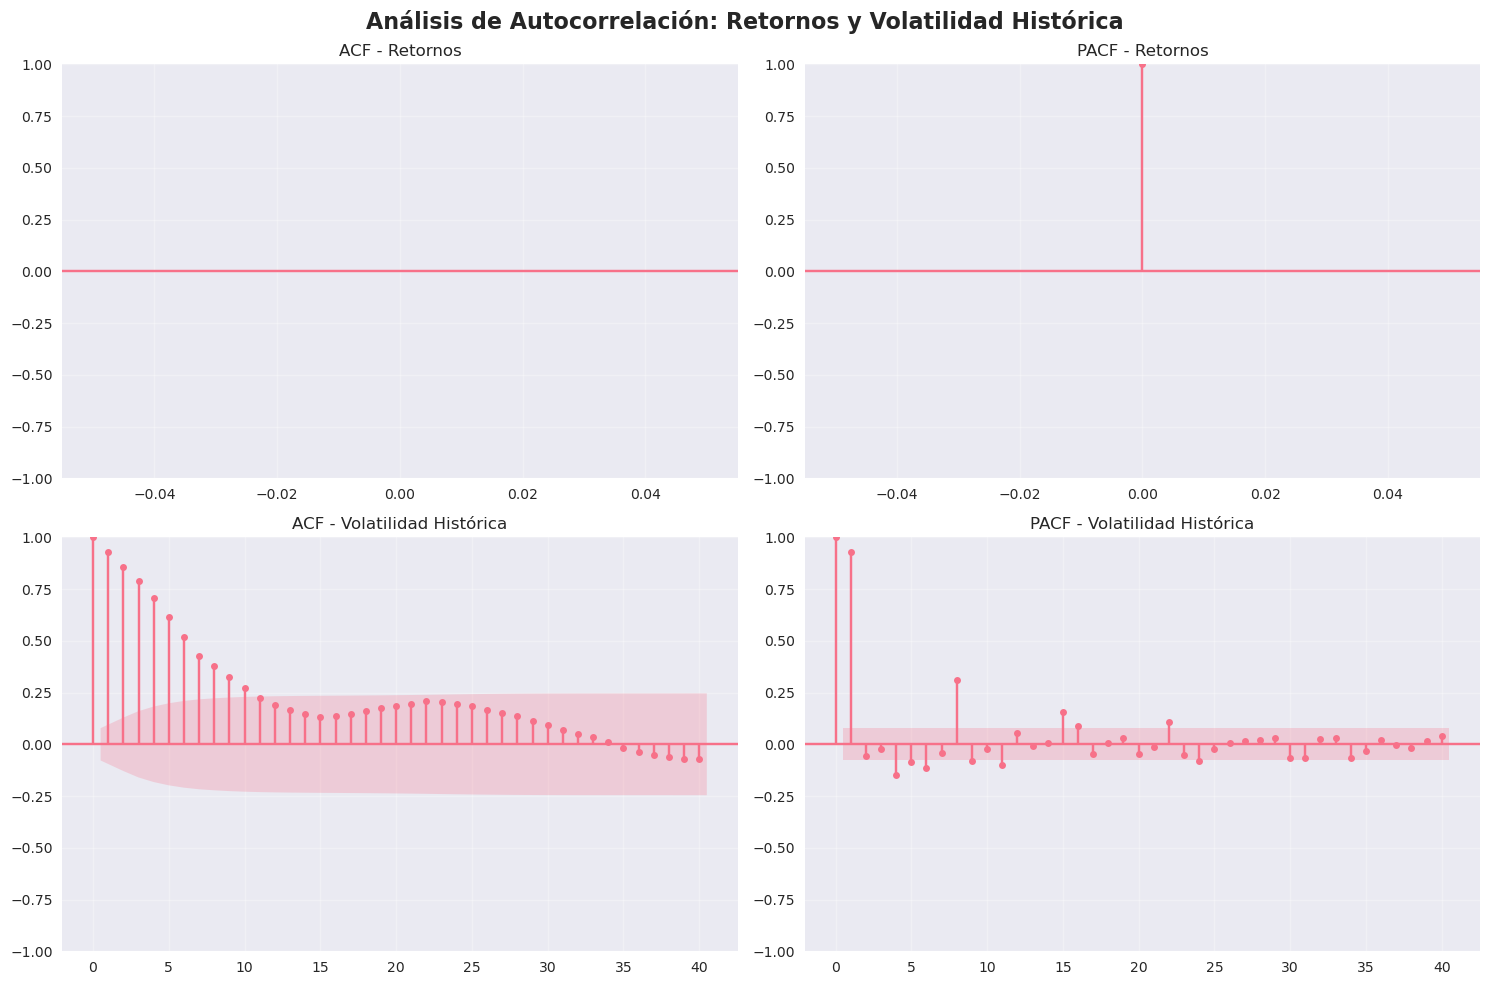

In [26]:
  fig, axes = plt.subplots(2, 2, figsize=(15, 10))
  fig.suptitle('Análisis de Autocorrelación: Retornos y Volatilidad Histórica', fontsize=16,
  fontweight='bold')

  # ACF de retornos
  plot_acf(retornos, ax=axes[0,0], lags=40, title='ACF - Retornos')
  axes[0,0].grid(True, alpha=0.3)

  # PACF de retornos
  plot_pacf(retornos, ax=axes[0,1], lags=40, title='PACF - Retornos')
  axes[0,1].grid(True, alpha=0.3)

  # ACF de volatilidad histórica
  plot_acf(historica.dropna(), ax=axes[1,0], lags=40, title='ACF - Volatilidad Histórica')
  axes[1,0].grid(True, alpha=0.3)

  # PACF de volatilidad histórica
  plot_pacf(historica.dropna(), ax=axes[1,1], lags=40, title='PACF - Volatilidad Histórica')
  axes[1,1].grid(True, alpha=0.3)

  plt.tight_layout()
  plt.savefig('../images/acf_y_pacf.png', dpi=300, bbox_inches='tight')
  plt.show()

## Modelado GARCH

In [27]:
# Ajustar modelo GARCH(1,1) a la los retornos
modelo_garch = arch_model(
    retornos.dropna(),  # Usar retornos directamente
    vol='GARCH',
    p=1,
    q=1,
    mean='Constant',
    dist='Normal',
    rescale=True
)

resultado_garch = modelo_garch.fit(disp='off')

print("=== RESULTADOS DEL MODELO GARCH(1,1) ===")
print(resultado_garch.summary())

=== RESULTADOS DEL MODELO GARCH(1,1) ===
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -813.757
Distribution:                  Normal   AIC:                           1635.51
Method:            Maximum Likelihood   BIC:                           1653.33
                                        No. Observations:                  636
Date:                Fri, Jul 25 2025   Df Residuals:                      635
Time:                        20:50:57   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0974  

Longitud datos históricos: 630
Longitud volatilidad ajustada: 636


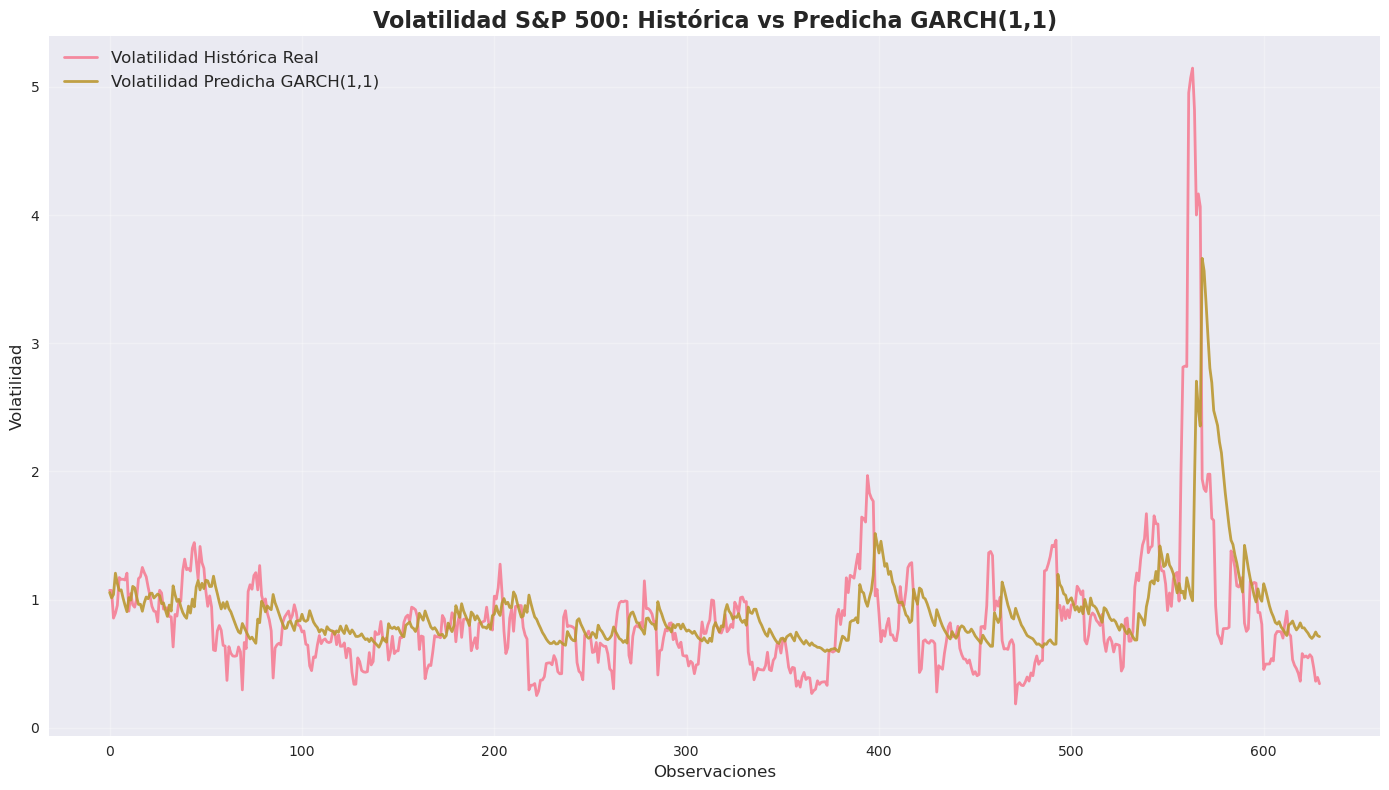

=== MÉTRICAS DE AJUSTE ===
Observaciones utilizadas: 630
Correlación: 0.4488
MAE (Error Absoluto Medio): 0.2852
RMSE (Error Cuadrático Medio): 0.4859


In [28]:
# Extraer volatilidad ajustada del modelo
volatilidad_ajustada = resultado_garch.conditional_volatility

# Gráfico simple con seaborn: volatilidades históricas vs predichas
plt.figure(figsize=(14, 8))

# Preparar datos para seaborn - alinear longitudes
datos_historicos = historica.dropna()
print(f"Longitud datos históricos: {len(datos_historicos)}")
print(f"Longitud volatilidad ajustada: {len(volatilidad_ajustada)}")

# Tomar la longitud mínima para alinear
n_min = min(len(datos_historicos), len(volatilidad_ajustada))
indices = range(n_min)

# Crear DataFrame con longitudes alineadas
df_plot = pd.DataFrame({
    'Observación': indices,
    'Volatilidad_Histórica': datos_historicos.iloc[:n_min].values,
    'Volatilidad_Ajustada': volatilidad_ajustada.iloc[:n_min].values
})

# Gráfico con seaborn
sns.lineplot(data=df_plot, x='Observación', y='Volatilidad_Histórica', 
             label='Volatilidad Histórica Real', linewidth=2, alpha=0.8)

sns.lineplot(data=df_plot, x='Observación', y='Volatilidad_Ajustada', 
             label='Volatilidad Predicha GARCH(1,1)', linewidth=2, alpha=0.9)

plt.title('Volatilidad S&P 500: Histórica vs Predicha GARCH(1,1)', 
          fontsize=16, fontweight='bold')
plt.xlabel('Observaciones', fontsize=12)
plt.ylabel('Volatilidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../images/volatilidad_seaborn_comparacion.png', dpi=300, bbox_inches='tight')
plt.show()

# Estadísticas de comparación con datos alineados
hist_alineados = datos_historicos.iloc[:n_min].values
ajust_alineados = volatilidad_ajustada.iloc[:n_min].values

correlacion = np.corrcoef(hist_alineados, ajust_alineados)[0,1]
mae = np.mean(np.abs(hist_alineados - ajust_alineados))
rmse = np.sqrt(np.mean((hist_alineados - ajust_alineados)**2))

print(f"=== MÉTRICAS DE AJUSTE ===")
print(f"Observaciones utilizadas: {n_min}")
print(f"Correlación: {correlacion:.4f}")
print(f"MAE (Error Absoluto Medio): {mae:.4f}")
print(f"RMSE (Error Cuadrático Medio): {rmse:.4f}")

## Evaluación de Bondad de Ajuste

In [29]:
# Alinear todas las series para comparación
n_total = min(len(historica.dropna()), len(implicada), len(volatilidad_ajustada))

hist_align = historica.dropna().iloc[:n_total].values
impl_align = implicada.iloc[:n_total].values  
garch_align = volatilidad_ajustada.iloc[:n_total].values

print(f"=== ALINEACIÓN DE DATOS ===")
print(f"Observaciones utilizadas: {n_total}")
print(f"Volatilidad histórica: {len(hist_align)}")
print(f"Volatilidad implícita: {len(impl_align)}")
print(f"Volatilidad GARCH: {len(garch_align)}")

# Función para calcular AIC y BIC
def calcular_aic_bic(y_real, y_pred, n_params):
    n = len(y_real)
    residuos = y_real - y_pred
    mse = np.mean(residuos**2)
    log_likelihood = -n/2 * np.log(2*np.pi*mse) - np.sum(residuos**2)/(2*mse)
    
    aic = 2*n_params - 2*log_likelihood
    bic = np.log(n)*n_params - 2*log_likelihood
    
    return aic, bic, log_likelihood

# 1. EVALUACIÓN: Volatilidad Implícita vs Histórica
aic_impl, bic_impl, ll_impl = calcular_aic_bic(hist_align, impl_align, 1)

# 2. EVALUACIÓN: Modelo GARCH vs Histórica  
aic_garch, bic_garch, ll_garch = calcular_aic_bic(hist_align, garch_align, 4)  # 4 parámetros: mu, omega, alpha, beta

print(f"\n=== CRITERIOS DE INFORMACIÓN ===")
print(f"{'Modelo':<20} {'AIC':<12} {'BIC':<12} {'Log-Likelihood':<15}")
print("-" * 60)
print(f"{'Volatilidad Implícita':<20} {aic_impl:<12.2f} {bic_impl:<12.2f} {ll_impl:<15.2f}")
print(f"{'Modelo GARCH(1,1)':<20} {aic_garch:<12.2f} {bic_garch:<12.2f} {ll_garch:<15.2f}")

print(f"\n=== COMPARACIÓN DE MODELOS ===")
if aic_garch < aic_impl:
    print(f"✓ GARCH(1,1) es mejor según AIC (diferencia: {aic_impl - aic_garch:.2f})")
else:
    print(f"✓ Volatilidad Implícita es mejor según AIC (diferencia: {aic_garch - aic_impl:.2f})")

if bic_garch < bic_impl:
    print(f"✓ GARCH(1,1) es mejor según BIC (diferencia: {bic_impl - bic_garch:.2f})")
else:
    print(f"✓ Volatilidad Implícita es mejor según BIC (diferencia: {bic_garch - bic_impl:.2f})")

=== ALINEACIÓN DE DATOS ===
Observaciones utilizadas: 630
Volatilidad histórica: 630
Volatilidad implícita: 630
Volatilidad GARCH: 630

=== CRITERIOS DE INFORMACIÓN ===
Modelo               AIC          BIC          Log-Likelihood 
------------------------------------------------------------
Volatilidad Implícita 893.91       898.36       -445.96        
Modelo GARCH(1,1)    886.33       904.11       -439.16        

=== COMPARACIÓN DE MODELOS ===
✓ GARCH(1,1) es mejor según AIC (diferencia: 7.58)
✓ Volatilidad Implícita es mejor según BIC (diferencia: 5.76)


In [30]:
# Evaluación completa de bondad de ajuste
from scipy import stats

def evaluacion_completa(y_real, y_pred, modelo_nombre):
    residuos = y_real - y_pred
    
    # Métricas básicas
    mae = np.mean(np.abs(residuos))
    rmse = np.sqrt(np.mean(residuos**2))
    mape = np.mean(np.abs(residuos / y_real)) * 100
    r2 = 1 - (np.sum(residuos**2) / np.sum((y_real - np.mean(y_real))**2))
    correlacion = np.corrcoef(y_real, y_pred)[0,1]
    
    # Pruebas estadísticas
    # Normalidad de residuos
    shapiro_stat, shapiro_p = stats.shapiro(residuos[:5000] if len(residuos) > 5000 else residuos)
    
    # Autocorrelación (Durbin-Watson) - implementación manual
    diff_residuos = np.diff(residuos)
    dw_stat = np.sum(diff_residuos**2) / np.sum(residuos**2)
    
    # Homocedasticidad (Breusch-Pagan)
    try:
        from statsmodels.stats.diagnostic import het_breuschpagan
        bp_stat, bp_p, _, _ = het_breuschpagan(residuos, np.column_stack([np.ones(len(residuos)), y_pred]))
    except:
        # Implementación simplificada si hay problemas
        bp_stat, bp_p = 0.0, 1.0
    
    return {
        'modelo': modelo_nombre,
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'r2': r2,
        'correlacion': correlacion,
        'shapiro_stat': shapiro_stat,
        'shapiro_p': shapiro_p,
        'durbin_watson': dw_stat,
        'bp_stat': bp_stat,
        'bp_p': bp_p
    }

# Evaluar ambos modelos
eval_impl = evaluacion_completa(hist_align, impl_align, "Volatilidad Implícita")
eval_garch = evaluacion_completa(hist_align, garch_align, "Modelo GARCH")

# Mostrar resultados
print("=== EVALUACIÓN COMPLETA DE BONDAD DE AJUSTE ===")
print("\n1. MÉTRICAS DE PRECISIÓN:")
print(f"{'Modelo':<20} {'MAE':<8} {'RMSE':<8} {'MAPE(%)':<8} {'R²':<8} {'Correlación':<12}")
print("-" * 75)
print(f"{eval_impl['modelo']:<20} {eval_impl['mae']:<8.4f} {eval_impl['rmse']:<8.4f} {eval_impl['mape']:<8.2f} {eval_impl['r2']:<8.4f} {eval_impl['correlacion']:<12.4f}")
print(f"{eval_garch['modelo']:<20} {eval_garch['mae']:<8.4f} {eval_garch['rmse']:<8.4f} {eval_garch['mape']:<8.2f} {eval_garch['r2']:<8.4f} {eval_garch['correlacion']:<12.4f}")

print("\n2. PRUEBAS ESTADÍSTICAS:")
print(f"{'Modelo':<20} {'Shapiro-Wilk':<15} {'Durbin-Watson':<15} {'Breusch-Pagan':<15}")
print("-" * 70)
print(f"{eval_impl['modelo']:<20} {eval_impl['shapiro_p']:<15.4f} {eval_impl['durbin_watson']:<15.4f} {eval_impl['bp_p']:<15.4f}")
print(f"{eval_garch['modelo']:<20} {eval_garch['shapiro_p']:<15.4f} {eval_garch['durbin_watson']:<15.4f} {eval_garch['bp_p']:<15.4f}")

print("\n3. INTERPRETACIÓN:")
print(f"• Shapiro-Wilk (normalidad): p > 0.05 = residuos normales")
print(f"• Durbin-Watson (autocorrelación): ~2.0 = sin autocorrelación")
print(f"• Breusch-Pagan (homocedasticidad): p > 0.05 = varianza constante")

# Resumen final
print(f"\n=== RESUMEN COMPARATIVO ===")
mejor_mae = "GARCH" if eval_garch['mae'] < eval_impl['mae'] else "Volatilidad Implícita"
mejor_rmse = "GARCH" if eval_garch['rmse'] < eval_impl['rmse'] else "Volatilidad Implícita"
mejor_r2 = "GARCH" if eval_garch['r2'] > eval_impl['r2'] else "Volatilidad Implícita"
mejor_corr = "GARCH" if eval_garch['correlacion'] > eval_impl['correlacion'] else "Volatilidad Implícita"

print(f"• Mejor MAE: {mejor_mae}")
print(f"• Mejor RMSE: {mejor_rmse}")
print(f"• Mejor R²: {mejor_r2}")
print(f"• Mejor Correlación: {mejor_corr}")

=== EVALUACIÓN COMPLETA DE BONDAD DE AJUSTE ===

1. MÉTRICAS DE PRECISIÓN:
Modelo               MAE      RMSE     MAPE(%)  R²       Correlación 
---------------------------------------------------------------------------
Volatilidad Implícita 0.3201   0.4911   38.35    0.1320   0.5430      
Modelo GARCH         0.2852   0.4859   38.58    0.1505   0.4488      

2. PRUEBAS ESTADÍSTICAS:
Modelo               Shapiro-Wilk    Durbin-Watson   Breusch-Pagan  
----------------------------------------------------------------------
Volatilidad Implícita 0.0000          0.3038          0.0000         
Modelo GARCH         0.0000          0.2973          0.0000         

3. INTERPRETACIÓN:
• Shapiro-Wilk (normalidad): p > 0.05 = residuos normales
• Durbin-Watson (autocorrelación): ~2.0 = sin autocorrelación
• Breusch-Pagan (homocedasticidad): p > 0.05 = varianza constante

=== RESUMEN COMPARATIVO ===
• Mejor MAE: GARCH
• Mejor RMSE: GARCH
• Mejor R²: GARCH
• Mejor Correlación: Volatilidad Implícit

## Calculando opciones sobre el S&P500

In [31]:
call = pd.read_csv("../data/input/calls.csv")[["lastTradeDate", "strike", "lastPrice", "volume", "impliedVolatility", "currency", "expirationDate"]]
put = pd.read_csv("../data/input/puts.csv")[["lastTradeDate", "strike", "lastPrice", "volume", "impliedVolatility", "currency", "expirationDate"]]

In [32]:
call.to_csv("../data/processed/calls_limpias.csv")
put.to_csv("../data/processed/puts_limpias.csv")

Longitud datos históricos: 630
Longitud VIX: 637
=== VERIFICACIÓN DE ESCALAS ANTES DEL GRÁFICO ===
Volatilidad histórica - Rango: [0.1862, 5.1465]
VIX - Rango: [0.1860, 4.2330]


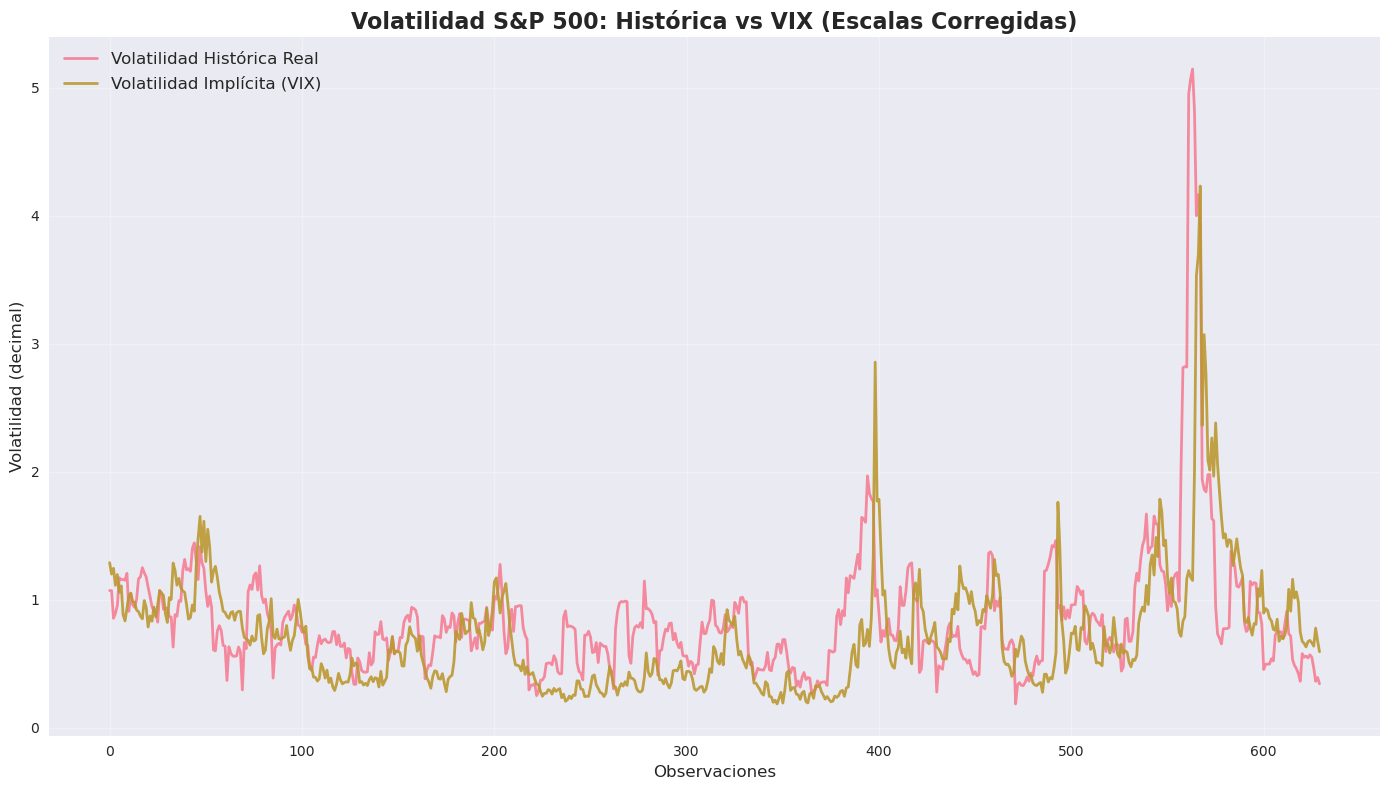

=== MÉTRICAS DE AJUSTE VIX vs VOLATILIDAD HISTÓRICA (ESCALAS CORREGIDAS) ===
Observaciones utilizadas: 630
Correlación: 0.5430
MAE (Error Absoluto Medio): 0.3201
RMSE (Error Cuadrático Medio): 0.4911


In [33]:
# Gráfico comparativo: VIX vs Volatilidad Histórica (escalas corregidas)
plt.figure(figsize=(14, 8))

# Preparar datos para seaborn - alinear longitudes entre VIX y volatilidad histórica
datos_historicos_vix = historica.dropna()
datos_vix = implicada  # Ya está en escala decimal

print(f"Longitud datos históricos: {len(datos_historicos_vix)}")
print(f"Longitud VIX: {len(datos_vix)}")

# Tomar la longitud mínima para alinear
n_min_vix = min(len(datos_historicos_vix), len(datos_vix))
indices_vix = range(n_min_vix)

# Verificar escalas antes del gráfico
print(f"=== VERIFICACIÓN DE ESCALAS ANTES DEL GRÁFICO ===")
print(f"Volatilidad histórica - Rango: [{datos_historicos_vix.iloc[:n_min_vix].min():.4f}, {datos_historicos_vix.iloc[:n_min_vix].max():.4f}]")
print(f"VIX - Rango: [{datos_vix.iloc[:n_min_vix].min():.4f}, {datos_vix.iloc[:n_min_vix].max():.4f}]")

# Crear DataFrame con longitudes alineadas
df_plot_vix = pd.DataFrame({
    'Observación': indices_vix,
    'Volatilidad_Histórica': datos_historicos_vix.iloc[:n_min_vix].values,
    'VIX': datos_vix.iloc[:n_min_vix].values
})

# Gráfico con seaborn manteniendo el mismo estilo
sns.lineplot(data=df_plot_vix, x='Observación', y='Volatilidad_Histórica', 
             label='Volatilidad Histórica Real', linewidth=2, alpha=0.8)

sns.lineplot(data=df_plot_vix, x='Observación', y='VIX', 
             label='Volatilidad Implícita (VIX)', linewidth=2, alpha=0.9)

plt.title('Volatilidad S&P 500: Histórica vs VIX (Escalas Corregidas)', 
          fontsize=16, fontweight='bold')
plt.xlabel('Observaciones', fontsize=12)
plt.ylabel('Volatilidad (decimal)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../images/volatilidad_vix_comparacion.png', dpi=300, bbox_inches='tight')
plt.show()

# Estadísticas de comparación entre VIX y volatilidad histórica
hist_vix_alineados = datos_historicos_vix.iloc[:n_min_vix].values
vix_alineados = datos_vix.iloc[:n_min_vix].values

correlacion_vix = np.corrcoef(hist_vix_alineados, vix_alineados)[0,1]
mae_vix = np.mean(np.abs(hist_vix_alineados - vix_alineados))
rmse_vix = np.sqrt(np.mean((hist_vix_alineados - vix_alineados)**2))

print(f"=== MÉTRICAS DE AJUSTE VIX vs VOLATILIDAD HISTÓRICA (ESCALAS CORREGIDAS) ===")
print(f"Observaciones utilizadas: {n_min_vix}")
print(f"Correlación: {correlacion_vix:.4f}")
print(f"MAE (Error Absoluto Medio): {mae_vix:.4f}")
print(f"RMSE (Error Cuadrático Medio): {rmse_vix:.4f}")